In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, time, datetime
import time

In [2]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import ElementNotInteractableException, StaleElementReferenceException

In [3]:
import shutil

__ALWAYS RUN FIRST__

Setting correct date for data

Hour references in the code are set for PST, please change if your current timezone is different

In [4]:
today = date.today()
now = datetime.now()
hour = now.hour
day = today.weekday()
day_dic = {0: 'Monday', 1: 'Tueday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
day_name = day_dic[day]
print(f'It is {day_name} {now} now')
print('Hour references in the code are set for PST, please change if your current timezone is different.')
if day > 4:
    today = today - timedelta(days = day-4)
elif 0 <= hour < 6:
    today = today - timedelta(days = 1)
elif 6 <= hour < 13:
    raise Exception('Market is currently in trading hours, please wait until it closes to gather data.')
day_name = day_dic[today.weekday()]
print(f'All set to gather data for {day_name} {today}')

It is Friday 2021-07-09 13:04:05.186934 now
Hour references in the code are set for PST, please change if your current timezone is different.
All set to gather data for Friday 2021-07-09


In [5]:
driver = webdriver.Chrome('C:/Users/seant/OneDrive/Desktop/chromedriver_win32/chromedriver.exe')

Closing price and trade volume (cptv) by minute datatable

In [6]:
adv_chart_url = 'https://www.nasdaq.com/market-activity/stocks/amzn/advanced-charting/'
driver.get(adv_chart_url)
driver.switch_to.window(driver.window_handles[0])
driver.switch_to.default_content()

In [7]:
graph_frame = driver.find_element_by_xpath('//*[@id="chartholder"]/iframe')
driver.switch_to.frame(graph_frame)
period_button = driver.find_element_by_id('periodBtn')
ActionChains(driver).move_to_element(period_button).click().perform()
min_period = driver.find_element_by_xpath('//*[@id="periodicity"]/li[5]')
ActionChains(driver).move_to_element(min_period).click().perform()
table_button = driver.find_element_by_id("dataTableBtn")
table_button.click()
driver.switch_to.default_content()
table_frame = driver.find_element_by_xpath('//*[@id="chartholder"]/iframe')
driver.switch_to.frame(table_frame)
wait = WebDriverWait(driver, 10)
export_to_excel_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@onclick="window.grid.exportToExcel()"]')))
ActionChains(driver).move_to_element(export_to_excel_button).click().perform()
print('Done')

Done


Moving downloaded cptv by minute datatable to correct folder

In [8]:
time.sleep(30)
old_excel_dir = 'C:/Users/seant/Downloads/grid.xls'
today_data = f'closing_price_trade_volume_data/AMZN_cptv_{today}.xls'
new_dir = f'C:/Users/seant/stock_analyzer/{today_data}'
shutil.move(old_excel_dir, new_dir);

Real time trades datatable

In [9]:
real_time_trades_url = 'https://www.nasdaq.com/market-activity/stocks/amzn/latest-real-time-trades'
driver.get(real_time_trades_url)
driver.switch_to.default_content()

In [10]:
driver.switch_to.window(driver.window_handles[0])
time.sleep(2)
time_list = ['9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30']
dropdown_menu = driver.find_element_by_class_name('latest-real-time-trades__dropdown-toggle')
dropdown_buttons = driver.find_elements_by_class_name('latest-real-time-trades__dropdown-option')
next_page_button = driver.find_element_by_class_name("pagination__next")
banner = driver.find_element_by_xpath("/html/body")
real_time_trades_data = []

table_page_buttons = driver.find_elements_by_class_name("pagination__page")
if banner.get_attribute('class') == 'path-market-activity with-header-ads with-header-ads--loaded' and driver.execute_script("return window.pageYOffset;") != 0:
    driver.execute_script("window.scrollBy(0, -200);")
ActionChains(driver).move_to_element(table_page_buttons[0]).click().perform()

row_count = 0

for i, time_section in enumerate(time_list):
    driver.execute_script("window.scroll(0, 0);")
    driver.execute_script("arguments[0].scrollIntoView();", dropdown_menu)
    time_section_clicked = False
    while time_section_clicked == False:

        try:
            if banner.get_attribute('class') == 'path-market-activity with-header-ads with-header-ads--loaded' and driver.execute_script("return window.pageYOffset;") != 0:
                driver.execute_script("window.scrollBy(0, -200);")
            ActionChains(driver).move_to_element(dropdown_menu).click().perform()
            driver.execute_script("arguments[0].scrollIntoView();", dropdown_buttons[i+1])
            ActionChains(driver).move_to_element(dropdown_buttons[i+1]).click().perform()
            time_section_clicked = True
        except ElementNotInteractableException:
            driver.execute_script("window.scrollBy(0, -200);")
            continue
    print(time_section)
    

    pages = 1
    while next_page_button.is_enabled() == True:
        
        ## function?
        row_count -= 1
        page_data_gathered = False
        row_count_buffer = 0
        data_buffer = []
        while page_data_gathered == False:
            try:
                real_time_trades_row = driver.find_elements_by_xpath('.//*[self::tr]')
                for i, row in enumerate(real_time_trades_row):
                    data_row = []
                    for j, item in enumerate(row.find_elements_by_xpath(".//*[self::td or self::th]")):
                        data_row.append(item.text)
                    row_count_buffer += 1
                    data_buffer.append(data_row)
                page_data_gathered = True
            except StaleElementReferenceException:
                row_count_buffer = 0
                data_buffer = []
                continue
        if page_data_gathered == True:
            row_count += row_count_buffer
            for row in data_buffer:
                real_time_trades_data.append(row)
        ##
        
        driver.execute_script("arguments[0].scrollIntoView();", next_page_button)
        ActionChains(driver).move_to_element(next_page_button).click().perform()
        pages += 1
        
    ## function?
    row_count -= 1
    page_data_gathered = False
    row_count_buffer = 0
    data_buffer = []
    while page_data_gathered == False:
        try:
            real_time_trades_row = driver.find_elements_by_xpath('.//*[self::tr]')
            for i, row in enumerate(real_time_trades_row):
                data_row = []
                for j, item in enumerate(row.find_elements_by_xpath(".//*[self::td or self::th]")):
                    data_row.append(item.text)
                row_count_buffer += 1
                data_buffer.append(data_row)
            page_data_gathered = True
        except StaleElementReferenceException:
            row_count_buffer = 0
            data_buffer = []
            continue
    if page_data_gathered == True:
        row_count += row_count_buffer
        for row in data_buffer:
            real_time_trades_data.append(row)
        ##
    print(pages)

    table_page_buttons = driver.find_elements_by_class_name("pagination__page")
    if banner.get_attribute('class') == 'path-market-activity with-header-ads with-header-ads--loaded' and driver.execute_script("return window.pageYOffset;") != 0:
        driver.execute_script("window.scrollBy(0, -200);")
    ActionChains(driver).move_to_element(table_page_buttons[0]).click().perform()

    time.sleep(0.5)
print('Done')
print(f'{row_count} number of rows')

9:30
164
10:00
35
10:30
31
11:00
24
11:30
18
12:00
13
12:30
10
13:00
10
13:30
11
14:00
14
14:30
11
15:00
11
15:30
42
Done
7741 number of rows


Real time trades data cleaning and put into a df

In [11]:
real_time_trades_df = pd.DataFrame.from_records(real_time_trades_data)
real_time_trades_df.columns = real_time_trades_df.iloc[0]
real_time_trades_df = real_time_trades_df[real_time_trades_df['NLS Time (ET)'] != 'NLS Time (ET)']

In [12]:
real_time_trades_df_copy = real_time_trades_df.copy()
real_time_trades_df_copy.reset_index(drop=True)
print(real_time_trades_df_copy.shape)

(7741, 3)


In [13]:
real_time_trades_csv = f'AMZN_rtt_{today}.csv'
real_time_trades_df.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/real_time_trades_data/{real_time_trades_csv}')

In [14]:
driver.quit()

Datatable analysis

Only cptv by minute datatable so far

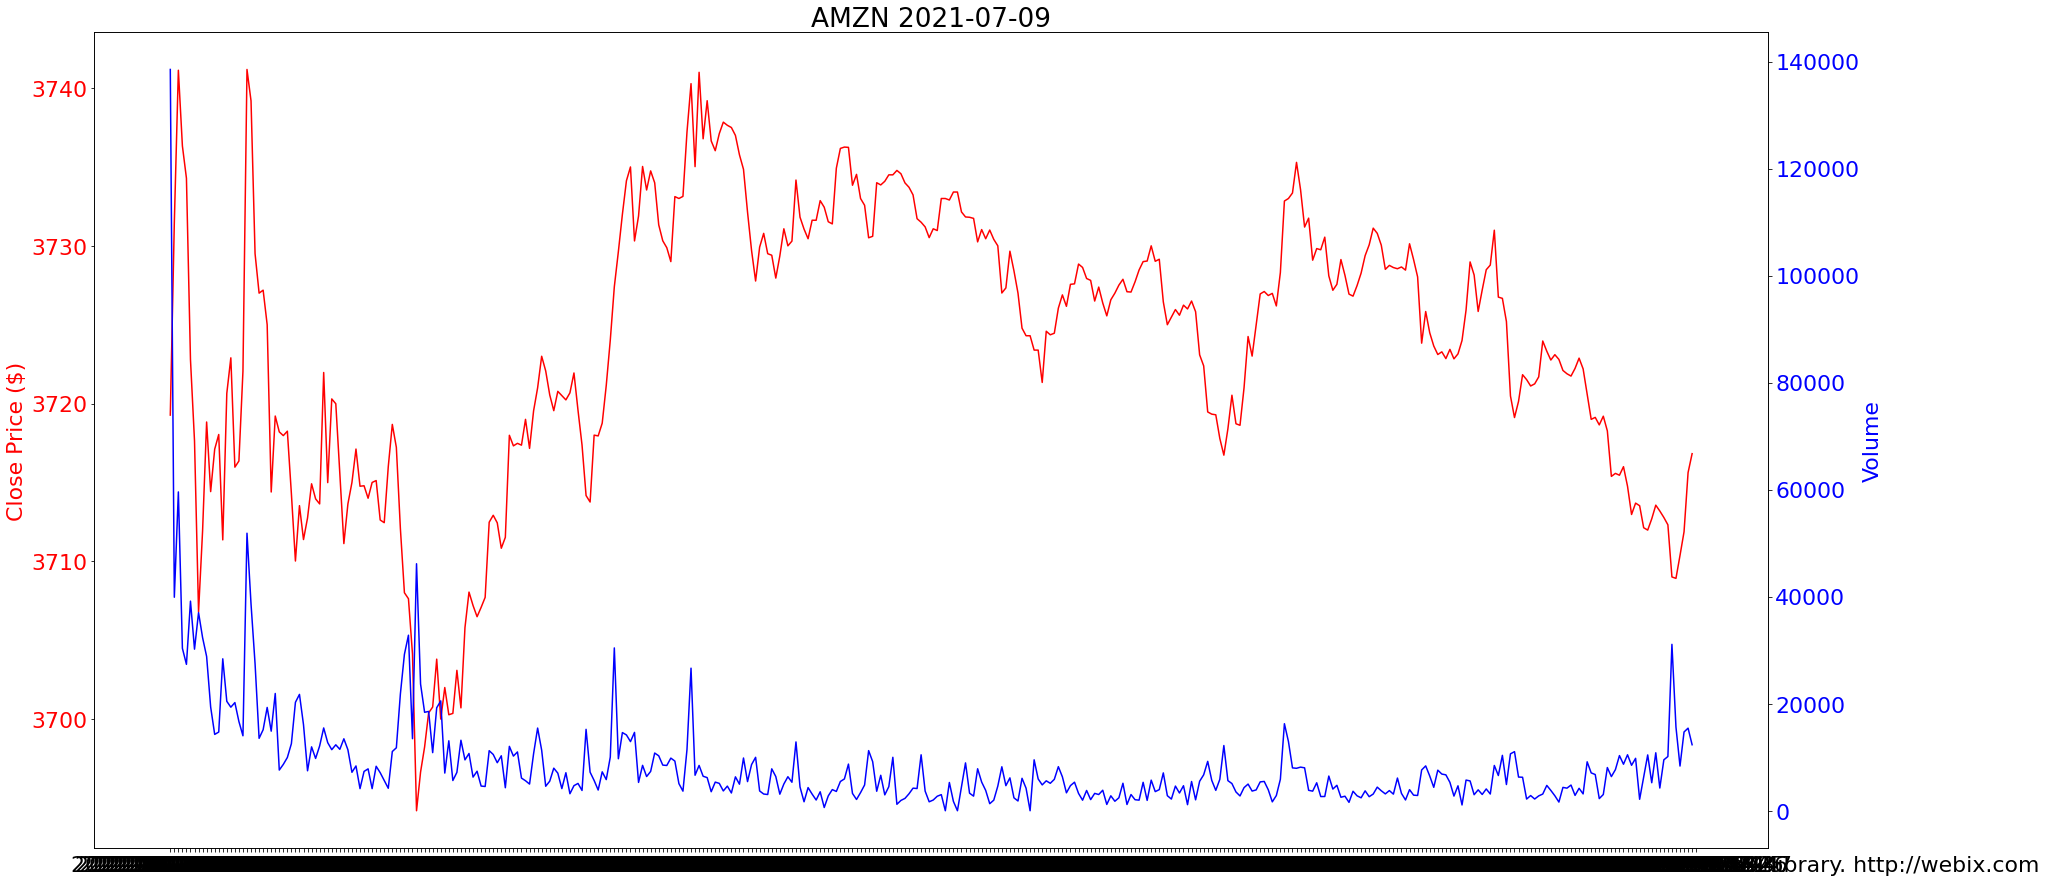

In [15]:
#change x ticks to be by the hour?
today_table = pd.read_excel(today_data)
date_array = today_table.loc[:, 'Date']

plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

ax1.plot(date_array, today_table.loc[:, 'Close'], color='r', label='Close')
ax1.set_ylabel('Close Price ($)', color ='r')
ax1.set_title(f'AMZN {today}')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(date_array, today_table.loc[:, 'Volume'], color='b', label='Volume')
ax2.set_ylabel('Volume', color ='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.show()